# Masking Method for Time Series
This notebook, designed for Google Colab, showcases a masking method for time series data with the mask_in_model approach. 
The masking of the input will be executed within the forward function of the model.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def patch_masking(x, mask_ratio, patch_size=10):
    """
    Perform per-sample random masking by creating non-overlapping patches.

    Args:
        x (torch.Tensor): Input tensor of shape [N, L, D].
        mask_ratio (float): Proportion of elements to mask.
        patch_size (int): Size of non-overlapping patches to create.

    Returns:
        tuple: (x_masked, mask) where x_masked is the masked input tensor and mask is the binary mask.
    """
    N, L, D = x.shape  # batch size, sequence length, dimension
    len_keep = int(L * (1 - mask_ratio))
    all_masked = (L - len_keep) // patch_size
    # Create a list to store masks for each sample
    batch_masks = []
    # For each sample
    for i in range(N):
        # Create a 1 tensor for the current sample's first channel
        mask_patches = torch.ones_like(x[i, :, 0])

        # Flatten the tensor into a 1D array
        flat_mask = mask_patches.flatten()

        # Convert to numpy array
        flat_mask_np = flat_mask.cpu().numpy()

        # Start at a random position
        # current_i = np.random.randint(0, L//2)
        current_i = np.random.randint(0, L)
        patches_applied = 0
        mask_chance = 0.1
        while patches_applied < all_masked:
            if np.random.rand() < mask_chance:
                # Mask the next patch_size elements
                end = min(current_i + patch_size, len(flat_mask_np))
                #add missing patches to beginn
                if end == len(flat_mask_np):
                    flat_mask_np[0:patch_size] = 0
                    patches_applied += 1
                    current_i = patch_size

                else:
                    # Mask the current position
                    flat_mask_np[current_i] = 0
                    # Mask the end positions
                    flat_mask_np[current_i:end] = 0
                    # Move to the end of the current patch
                    current_i = end
                    patches_applied += 1
            else:
                # Move to the next position
                current_i += 1

        print(f"patch applied {patches_applied} in batch {i} times with patch size {patch_size}. Keeping {len_keep} values out of {L}")
        # Convert back to torch tensor and reshape
        mask = torch.from_numpy(flat_mask_np).to(x.device)
        mask = mask.view_as(mask_patches)
        mask = mask.unsqueeze(-1)
        batch_masks.append(mask)

    # Stack all masks into a batch
    mask = torch.stack(batch_masks, dim=0)

    # Apply the mask to the input tensor 0 is removed elements and 1 keep, we remove mask ratio elements
    x_masked = x * mask
    mask = mask.squeeze(-1)
    return x_masked, mask

# Create Sinusoidal Sequence for Testing

This function creates a time series with sinusoidal patterns for each feature. The sinusoidal frequency increases
with each subsequent feature, simulating different variates in a time series setting.

In [ ]:
import torch
import torch.nn as nn
import numpy as np

def create_sinusoidal_sequence(batch_size: int = 32, sequence_length: int = 100, frequency: float = 1.0, n_features: int = 2, device: str = 'mps' if torch.backends.mps.is_available() else 'cpu') -> torch.Tensor:
    """
    Creates a sinusoidal sequence for testing.

    Args:
        batch_size (int): Number of samples in the batch.
        sequence_length (int): Length of the sequence.
        frequency (float): Frequency of the sinusoid.
        n_features (int): Number of features in the sequence.
        device (str): Device to create the tensor on.

    Returns:
        torch.Tensor: A tensor of shape [batch_size, sequence_length, n_features] representing the sinusoidal sequence.
    """
    device = torch.device(device)
    time_points = torch.linspace(0, 2 * np.pi, sequence_length, device=device)
    freq=2
    if n_features == 1:
        signal = torch.sin(frequency * time_points)
    else:
        features = []
        for i in range(n_features):
            if i == 0:
                feat = torch.sin(frequency * time_points)
            else:
                feat = torch.cos(frequency * freq * time_points)
                freq  += 1
            features.append(feat)
        signal = torch.stack(features, dim=1)

    signal = signal.unsqueeze(0)
    sequence = signal.repeat(batch_size, 1, 1)

    sequence = (sequence - sequence.mean(dim=1, keepdim=True)) / (sequence.std(dim=1, keepdim=True) + 1e-8)

    return sequence

# Create Model


In [ ]:
class BaseModel(nn.Module):
    def __init__(
        self, input_sequence_length: int, output_sequence_length: int, num_features: int
    ) -> None:
        super(BaseModel, self).__init__()
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        self.num_features = num_features

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError()

# Basic Autoencoder

In [ ]:
class AutoLin_Masking(BaseModel):
    def __init__(self, input_sequence_length: int, output_sequence_length: int, num_features: int):
        super(AutoLin_Masking, self).__init__(input_sequence_length, output_sequence_length, num_features)
        # Encoder layers
        self.encoder_layers = nn.ModuleList([
            nn.Linear(self.input_sequence_length, 2048),
            nn.Linear(2048, 512),

        ])

        # Decoder layers
        self.decoder_layers = nn.ModuleList([
            nn.Linear(512, 2048),
        ])
        self.seq_decoder = nn.Linear(2048, self.input_sequence_length)

    def encoder_forward(self, x):
        # Apply encoder layers
        for layer in self.encoder_layers:
            x = layer(x)
        return x

    def decoder_forward(self, x):
        # Apply decoder layers
        for layer in self.decoder_layers:
            x = layer(x)
        return x

    def forward(self, x):
        # Encode the input sequence
        x_masked, mask = patch_masking(x, mask_ratio=0.75, patch_size=128)
        mask = mask.unsqueeze(-1)
        x_masked = x.transpose(1, 2)
        encoder_output = self.encoder_forward(x_masked)
        # Decoder pass
        decoder_output = self.decoder_forward(encoder_output)

        # Final dense layer for output
        decoder_output = self.seq_decoder(decoder_output)
        decoder_output = decoder_output.transpose(1, 2)

        return decoder_output, mask

# Train Model
- loss.backward can be adjusted for example only seen areas
- the masking algorithm and hyperparameters can be changed for training

In [ ]:
def reconstruction_loss(x, reconstructed_x, mask, loss_fn, alpha=0.5):
    """
    Computes the reconstruction loss, applying loss only to masked positions,
    with optional monitoring of loss on visible positions.

    Args:
        x (torch.Tensor): Original input tensor of shape [batch_size, seq_len, num_features].
        reconstructed_x (torch.Tensor): Model's reconstructed input tensor, same shape as x.
        mask (torch.Tensor): Binary mask of shape [batch_size, seq_len, num_features] where 1 indicates the position was visible (unmasked) and 0 indicates it was masked.
        loss_fn (callable): Loss function, e.g., nn.MSELoss(reduction='none').
        alpha (float, optional): Weighting factor for the loss on visible positions. Defaults to 0.5.

    Returns:
        tuple: (loss_removed, loss_seen, total_loss)
    """
    # Compute element-wise loss between reconstructed and original input
    loss_values = loss_fn(reconstructed_x, x)  # Shape: [batch_size, seq_len, num_features]

    # Calculate loss only on masked (removed) positions
    loss_removed = (loss_values * (1 - mask)).sum() / ((1 - mask).sum())

    # Calculate loss on observed (seen) positions for monitoring
    loss_seen = (loss_values * mask).sum() / (mask.sum())

    # Combine losses with weighting factor alpha for seen loss
    total_loss = loss_removed + alpha * loss_seen

    return loss_removed, loss_seen, total_loss

def train_model(model, x, epochs=100, learning_rate=0.001):
    # Define loss function and optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Move data to device
    x = x.to(next(model.parameters()).device)

    # Training loop
    for epoch in range(epochs):
        # Forward pass
        out, mask = model(x)
        loss_fn = nn.MSELoss(reduction='none')  # Use per-element loss

        _, _, total_loss = reconstruction_loss(x, out, mask, loss_fn, 0.5)

        # Backward pass and optimize
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if epoch % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}')

    return model

# Example usage
if __name__ == "__main__":
    # Create data
    batch_size = 2
    sequence_length = 720
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    x = create_sinusoidal_sequence(batch_size=batch_size, sequence_length=sequence_length, n_features=25, device=device)
    # Initialize model
    model = AutoLin_Masking(input_sequence_length=sequence_length, output_sequence_length=sequence_length, num_features=25)
    # Train model
    trained_model = train_model(model, x, epochs=100, learning_rate=0.0005)


patch applied 4 in batch 0 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 1 times with patch size 128. Keeping 180 values out of 720
Epoch [1/100], Loss: 37.9039
patch applied 4 in batch 0 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 1 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 0 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 1 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 0 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 1 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 0 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 1 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 0 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 1 times with patch siz

patch applied 4 in batch 0 times with patch size 128. Keeping 180 values out of 720
patch applied 4 in batch 1 times with patch size 128. Keeping 180 values out of 720


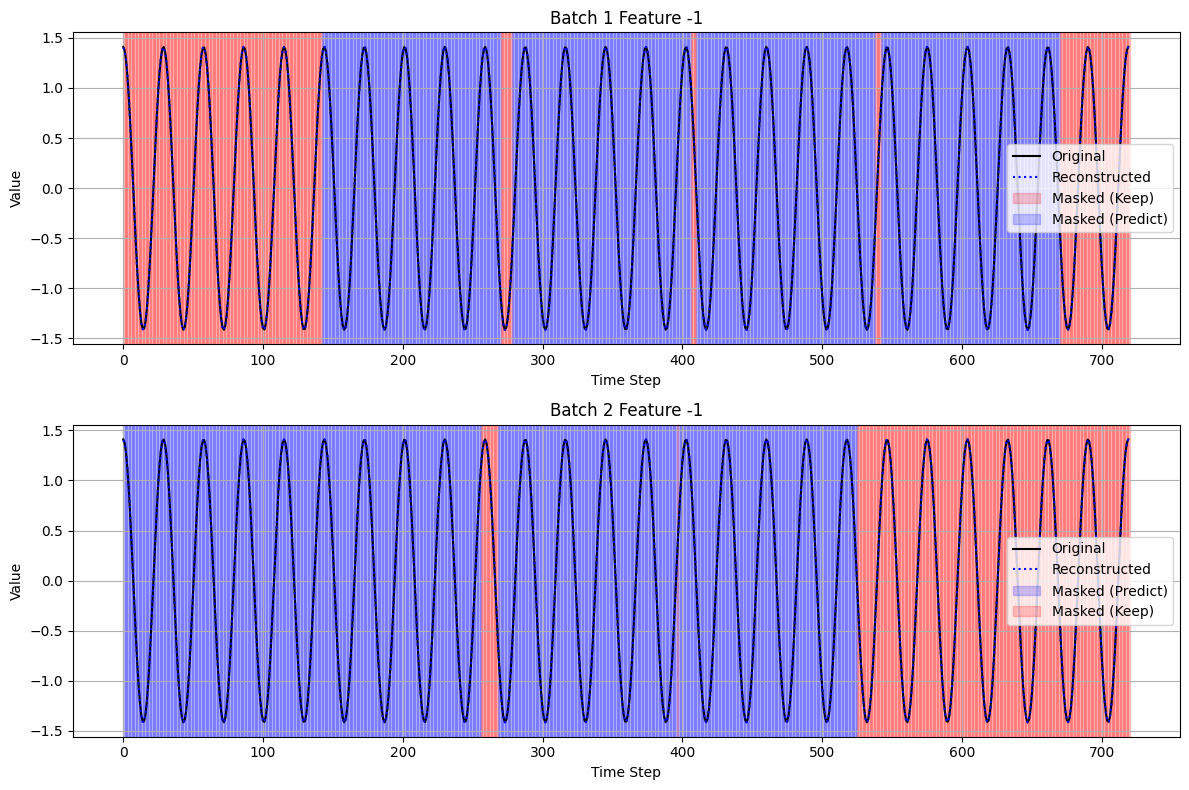

In [ ]:
trained_model.eval()
# Set feature_dim to the index of the last feature
feature_dim = -1

out, mask = trained_model(x)

plt.figure(figsize=(12, 4 * batch_size))
for batch in range(batch_size):
    plt.subplot(batch_size, 1, batch + 1)
    plt.plot(x[batch, :, feature_dim].cpu().numpy(), label='Original', alpha=1, color="black")
    plt.plot(out[batch, :, feature_dim].detach().numpy(), label='Reconstructed', alpha=1, color="blue", linestyle='dotted')
    mask_added_ax1 = False
    inv_mask_added_ax1 = False

    for t in range(sequence_length):
        if mask[batch, t] == 1:
            if not mask_added_ax1:
                plt.axvspan(t, t+1, color='red', alpha=0.2, label='Masked (Keep)')
                mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='red', alpha=0.2)
        else:
            if not inv_mask_added_ax1:
                plt.axvspan(t, t+1, color='blue', alpha=0.2, label='Masked (Predict)')
                inv_mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='blue', alpha=0.2)

    plt.legend()
    plt.title(f'Batch {batch+1} Feature -1')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

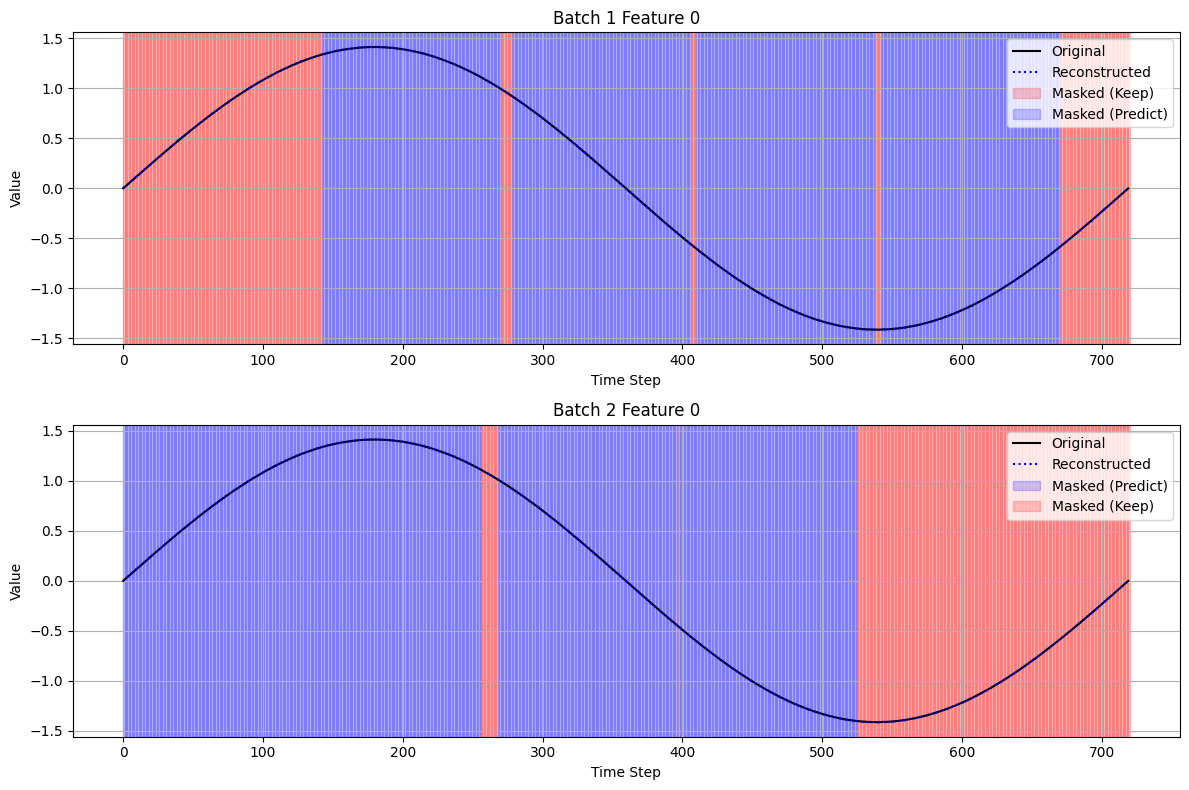

In [ ]:
plt.figure(figsize=(12, 4 * batch_size))
for batch in range(batch_size):
    plt.subplot(batch_size, 1, batch + 1)
    plt.plot(x[batch, :, 0].cpu().numpy(), label='Original', alpha=1, color="black")
    plt.plot(out[batch, :, 0].detach().numpy(), label='Reconstructed', alpha=1, color="blue", linestyle='dotted')
    mask_added_ax1 = False
    inv_mask_added_ax1 = False

    for t in range(sequence_length):
        if mask[batch, t] == 1:
            if not mask_added_ax1:
                plt.axvspan(t, t+1, color='red', alpha=0.2, label='Masked (Keep)')
                mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='red', alpha=0.2)
        else:
            if not inv_mask_added_ax1:
                plt.axvspan(t, t+1, color='blue', alpha=0.2, label='Masked (Predict)')
                inv_mask_added_ax1 = True
            else:
                plt.axvspan(t, t+1, color='blue', alpha=0.2)

    plt.legend()
    plt.title(f'Batch {batch+1} Feature 0')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.grid(True)

plt.tight_layout()
plt.show()